In [1]:
import numpy as np
from pathlib import Path
import pandas as pd
from sys import platform
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import medfilt
sns.set_style('ticks')
%matplotlib inline

In [2]:
vol_file = Path('../Voltron_data/Voltron_Log_DRN_Exp.csv')
swim_xls_file = pd.read_csv('analysis_sections_based_on_swim_pattern.csv', index_col=0)
swim_xls_file['folder'] = swim_xls_file['folder'].apply(lambda x: f'{x:0>8}')
if platform == "linux" or platform == "linux2":
    dir_folder = Path('/nrs/ahrens/Ziqiang/Takashi_DRN_project/ProcessedData/')
elif platform == 'win32':
    dir_folder = Path('U:\\Takashi') # put folder for windows system

## Swim pattern analysis

In [3]:
def swim_pca(row, ismean=True, isplot=True):
    from scipy.stats import ranksums
    from sklearn.decomposition import PCA, NMF
    
    folder = row['folder']
    fish = row['fish']
    task_type = row['task'][0]
    dat_dir = dir_folder/f'{folder}/{fish}/Data/'
    swim_dir = dir_folder/f'{folder}/{fish}/swim/'
    print(swim_dir)
    frame_stimParams = np.load(swim_dir/'frame_stimParams.npy')
    frame_swim_tcourse = np.load(swim_dir/'frame_swim_tcourse_series.npy')
    swim_starts = np.where(np.diff((frame_swim_tcourse[0,:]>0).astype('int'))==1)[0]
    swim_ends   = np.where(np.diff((frame_swim_tcourse[0,:]>0).astype('int'))==-1)[0]
    swim_ends   = swim_ends[((swim_starts>50) & (swim_starts<(frame_swim_tcourse.shape[1]-250)))]
    swim_starts = swim_starts[((swim_starts>50) & (swim_starts<(frame_swim_tcourse.shape[1]-250)))]
    task_period = frame_stimParams[2,swim_starts]
    task_index   = frame_stimParams[2,:]+(frame_stimParams[3,:]-1)*4+(frame_stimParams[4,:]-1)*12;
    swim_task_index =  task_index[swim_starts]
    swim_count  = np.zeros((len(swim_starts),))    
    ind_old=0
    for s in range(len(swim_starts)):
        ind=swim_task_index[s]
        if (ind>ind_old):
            swim_count[s]=1
            ind_old=ind
        elif (ind==ind_old):
            swim_count[s]=swim_count[s-1]+1

    ave_swim=np.empty((len(swim_starts),300))
    ave_swim[:] = 0 #np.nan
    ave_visu=np.empty((len(swim_starts),300))
    ave_visu[:] = 0 #np.nan
    ave_swim_len = np.zeros(len(swim_starts))

    for i in range(len(swim_starts)):
        swim_len = swim_ends[i] - swim_starts[i]
        if swim_len>250:
            swim_len = 250
        ave_swim_len[i] = swim_len
        ave_swim[i,:swim_len+50]=frame_swim_tcourse[2,(swim_starts[i]-50):(swim_starts[i]+swim_len)]*100000
        ave_visu[i,:swim_len+50]=-frame_stimParams[0,(swim_starts[i]-50):(swim_starts[i]+swim_len)]*10000
    
    num_comp = 10
    pca = PCA()#NMF(n_components=num_comp)#PCA()
    pca.fit(ave_swim[:, 50:200])
    x_ = pca.transform(ave_swim[:, 50:200]) 
    
    c_1 = 0
    c_2 = 1
    plt.plot(x_[task_period==1, c_1], x_[task_period==1, c_2], '.')
    plt.plot(x_[task_period==2, c_1], x_[task_period==2, c_2], '.')
    plt.xlabel('Component %d'%(c_1))
    plt.ylabel('Component %d'%(c_2))
    plt.show()
    
    plt.boxplot(x_[task_period==1, :])
    plt.ylim([x_.min(), x_.max()])
    plt.show()
    
    plt.boxplot(x_[task_period==2, :])
    plt.ylim([x_.min(), x_.max()])
    plt.show()
    
    return pca, x_

/nrs/ahrens/Ziqiang/Takashi_DRN_project/ProcessedData/03152018/Fish1-1/swim


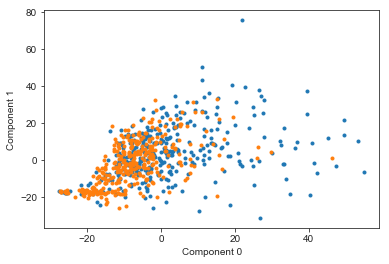

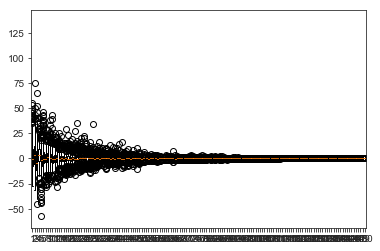

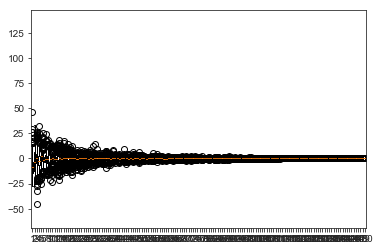

In [4]:
count = -1
for index, row in swim_xls_file.iterrows():
    count += 1
    if count != 0:        
        continue
    pca_, x_ = swim_pca(row)

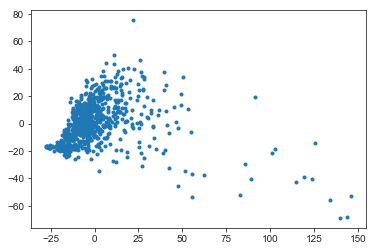

In [5]:
plt.plot(x_[:, 0], x_[:, 1], '.')
plt.show()

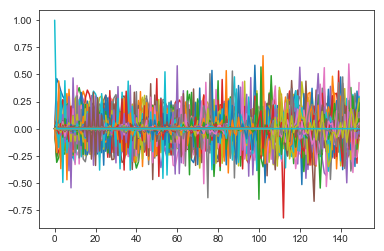

In [6]:
plt.plot(pca_.components_.T)
plt.show()